In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
from math import *
import random
import time
import re
import graphviz
import ast
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet, LassoCV, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.special import boxcox1p
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
full_data = pd.read_csv('full_data_clean_1.csv', index_col=0)
train_mask = full_data['SalePrice'] > 0
test_mask = full_data['SalePrice'] < 0

In [3]:
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)
full_data['MoSold'] = full_data['MoSold'].apply(str)
full_data = full_data.drop(['1stFlrSFAdj'], axis=1)
data = full_data[train_mask]
numerical = [f for f in full_data.columns if full_data.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in full_data.columns if full_data.dtypes[f] == 'object']
len(numerical), len(categorical)

(33, 42)

In [4]:
outlier_mask = test_mask | ((full_data['GrLivArea'] < 4000) & (full_data['LotArea'] < 100000) 
                            & (full_data['GrLivArea'] >= full_data['TotalBsmtSF']))
full_data = full_data.loc[outlier_mask]
full_data.shape

(2894, 77)

In [5]:
data = full_data.loc[train_mask]
data.shape

(1435, 77)

# Construct new target for predictions

In [6]:
X = data[['TotalBsmtSF', 'GrLivArea']]
y = data['SalePrice']
reg = LinearRegression(fit_intercept=True).fit(X,y)
reg.score(X,y)

0.6705799118280673

In [7]:
reg.coef_

array([79.26021933, 84.8202778 ])

In [8]:
reg.intercept_

-30962.999109076714

In [9]:
bsmt_cor = reg.coef_[0]/reg.coef_[1]
bsmt_cor

0.9344489476475691

In [10]:
full_data['SalePriceSF'] = full_data['SalePrice']/(full_data['GrLivArea'] + bsmt_cor * full_data['TotalBsmtSF'])
data = full_data.loc[train_mask]

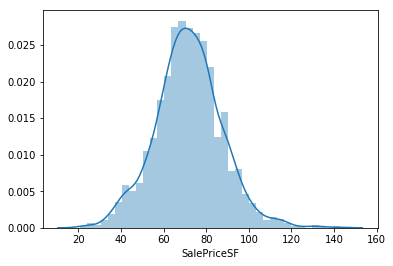

In [11]:
sns.distplot(data['SalePriceSF'])

((array([-3.30029702, -3.04273955, -2.89948811, ...,  2.89948811,
          3.04273955,  3.30029702]),
  array([ 20.79588593,  24.30766841,  24.79280398, ..., 131.22222184,
         134.68865148, 142.80598164])),
 (15.614405408680355, 71.68855482492552, 0.9960775779245186))

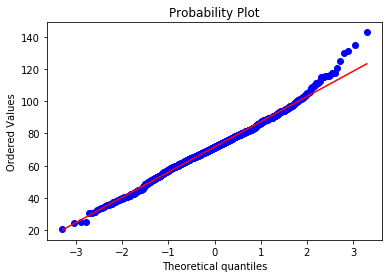

In [12]:
stats.probplot(data['SalePriceSF'], plot=plt)

# Feature Engineering

In [13]:
full_data['house_age'] = full_data['YrSold'] - full_data['YearBuilt']
data = full_data[train_mask]

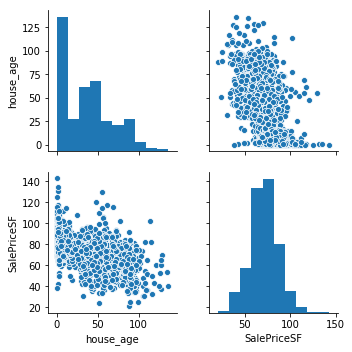

In [14]:
sns.pairplot(data[['house_age','SalePriceSF']])

In [15]:
full_data['is_new'] = (full_data['YrSold'] - full_data['YearBuilt']) < 2
full_data['is_new'] = full_data['is_new'].apply(str)
data =full_data[train_mask]
data.groupby('is_new')['SalePriceSF'].describe()

,count,mean,std,min,25%,50%,75%,max
is_new,,,,,,,,
False,1275.0,69.737454,14.559352,20.795886,60.892551,69.524647,79.111033,129.987908
True,160.0,87.236391,15.380966,38.317272,76.904326,85.267122,95.176050,142.805982


In [16]:
full_data = full_data.drop(['YearBuilt', 'YrSold'], axis=1)
data = full_data[train_mask]

In [17]:
stats.skew(full_data['house_age'])

0.5955138736354598

In [18]:
skewness = np.array([abs(stats.skew(boxcox1p(full_data['house_age'], (-5 + lam/10)))) for lam in range(100)])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:969: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


In [19]:
np.nanargmin(skewness)

56

# Remove skewness from the features

## Building custom transformer

In [23]:
# Apply different techniques to deal with feature skewness
class SkewnessRemover(BaseEstimator, TransformerMixin):
    #Constructor
    def __init__(self, lam=None, threshold=0.5):
        self.lam = lam
        self.threshold=threshold
        
    def fit(self, X, y=None):
        self.numerical = [f for f in X.columns if X.dtypes[f] != 'object']
        #print(self.numerical)
        return self
    
    def transform(self, X):
        for feat in self.numerical:
            if abs(stats.skew(X[feat])) > self.threshold:
                #print('{} has skew {:.4f}'.format(feat,stats.skew(X[feat])))
                if self.lam == None:
                    #autofit lambda for each skewed feature
                    skewness = np.array([abs(stats.skew(boxcox1p(X[feat]
                                                                 , (-5 + lam/10)))) for lam in range(100)])
                    lam = -5 + np.nanargmin(skewness)/10.0
                else:
                    lam = self.lam
                #print('lambda choosen {:.2f}'.format(lam))
                X[feat] = boxcox1p(X[feat], lam)
                #print('{} has got skew {:.4f}'.format(feat,stats.skew(X[feat])))
                #print()
        return X

In [24]:
X_tmp = full_data.drop(['Id', 'SalePrice', 'SalePriceSF'], axis=1).copy()
y_tmp = full_data['SalePrice']

In [25]:
skew_remover = SkewnessRemover(lam=0.15)
X_tmp = skew_remover.fit_transform(X_tmp, y_tmp)

# Categorical

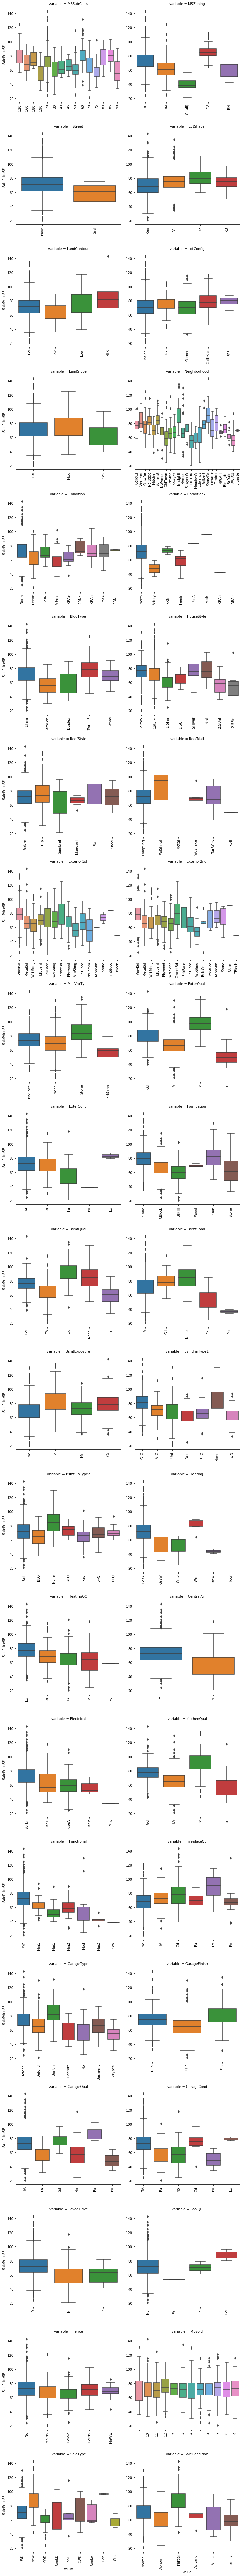

In [26]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(data, id_vars=['SalePriceSF'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePriceSF")

In [27]:
#Apply differen options for encoding categorical features
class EncoderForHouseData(BaseEstimator, TransformerMixin):
    #Constructor
    def __init__(self, method='dummies'):
        self.method = method
    
    def fit(self, X, y=None):
        self.categorical = [f for f in X.columns if X.dtypes[f] == 'object']
        return self
    
    #helper function
    def manualEncoding(self, X):
        X_new = X.copy()
        #print('inside manualEncoding')
        replace_map ={
            'MSZoning': {'C (all)':1, 'RM':2, 'RH':2, 'RL':3, 'FV': 4},
            'Street' : {'Grvl' : 1, 'Pave': 2},
            'LotShape' : {'Reg':0, 'IR1':1, 'IR3':1, 'IR2':2},
            'LandContour' : {'Bnk':1, 'Lvl':2, 'Low':3, 'HLS':4},
            'Condition1' : {'Artery':1, 'Feedr':2, 'RRAe':2, 'Norm':3, 'PosN':3, 'RRNn':3
                            , 'RRAn':3, 'PosA':3, 'RRNe':3},
            'Condition2' : {'Artery':1, 'Feedr':2, 'RRAe':2, 'Norm':3, 'PosN':3, 'RRNn':3
                            , 'RRAn':3, 'PosA':3, 'RRNe':3},
            'BldgType' : {'1Fam':2, '2fmCon':1, 'Duplex':1, 'TwnhsE':3, 'Twnhs':2},
            'MasVnrType' : {'BrkCmn':1, 'None':3, 'BrkFace':4, 'Stone':6, 'CBlock':4},
            'ExterQual' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'ExterCond' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':2, 'Ex':3},
            'Foundation' : {'PConc':1, 'Slab':1, 'CBlock':0, 'BrkTil':0, 'Stone':0, 'Wood':0},
            'BsmtQual' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4, 'None':4},
            'BsmtCond' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4, 'None':4},
            'BsmtExposure' : {'No':0, 'Mn': 1, 'Av': 2, 'Gd': 3},
            'Heating' : {'GasW': 0, 'Grav': 0, 'OthW': 0, 'GasA': 1, 'Floor':2, 'Wall':2},
            'HeatingQC' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'CentralAir' : {'Y': 1, 'N': 0},
            'Electrical' : {'SBrkr':1, 'FuseA':0, 'FuseF':0, 'FuseP':0, 'Mix':0},
            'KitchenQual' : {'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'Functional' : {'Typ':0, 'Min1': 1, 'Min2': 1, 'Mod':1, 'Maj1':2, 'Maj2':2, 'Sev':2, 'Sal':2},
            'FireplaceQu' : {'No': 0,'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'GarageFinish' : {'Unf': 0, 'RFn': 1, 'Fin':2},
            'GarageQual' : {'No': 1,'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'GarageCond' : {'No': 1,'Po': 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
            'PavedDrive' : {'Y': 1, 'N': 0, 'P': 0 },
            'is_new' : {'True': 1, 'False': 0}
            }
        to_remove = ['LotConfig', 'LandSlope', 'RoofStyle', 'RoofMatl', 'PoolQC', 'Fence', 'MoSold']
            
        X_new.replace(replace_map, inplace=True)
            
        X_new['Condition'] = X_new[['Condition1', 'Condition2']].apply(lambda row: min(row[0], row[1]), axis=1)
        X_new = X_new.drop(['Condition1', 'Condition2'], axis=1)
        X_new = X_new.drop(to_remove, axis=1)
        return X_new
    
    def transform(self, X):
        if self.method == 'dummies':
            return pd.get_dummies(X)
        elif self.method == 'mixed':
            X_new = self.manualEncoding(X)
            rest_cat = [f for f in X_new.columns if X_new.dtypes[f] == 'object']
            #print(rest_cat)
            #print(X_new.shape)
            return pd.get_dummies(X_new, drop_first=False)
        else:
            print('Wrong method name!')
            return X
    

# Feature selection

Define X, y, X_test. y2 - alternative predict variable (predict SF price)

In [28]:
X_train = full_data.loc[train_mask].drop(['Id','SalePrice', 'SalePriceSF'], axis=1)
y = full_data.loc[train_mask]['SalePrice'].apply(log)
y_SF = full_data.loc[train_mask]['SalePriceSF']
X_test = full_data.loc[test_mask].drop(['Id','SalePrice', 'SalePriceSF'], axis=1)

In [29]:
data = full_data.loc[train_mask]
data[data['LowQualFinSF'] > 0]['SalePriceSF'].describe()

count     26.000000
mean      57.494573
std       17.154171
min       34.376814
25%       43.380066
50%       56.342023
75%       64.430752
max      102.316996
Name: SalePriceSF, dtype: float64

In [30]:
data[data['LowQualFinSF'] == 0]['SalePriceSF'].describe()

count    1409.000000
mean       71.950474
std        15.505472
min        20.795886
25%        62.445784
50%        71.776073
75%        81.099524
max       142.805982
Name: SalePriceSF, dtype: float64

In [31]:
#todo custom feature selector

# Encoding the data and define scoring functions

In [32]:
def rmsle_cv(model, X, y, n_folds=10, random_state=17):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state).split(X)
    #print(kf)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

def rmsle_cv_stat(model, X, y, n_folds=10, n_tries=50):
    results = np.array([rmsle_cv(model, X, y, n_folds=n_folds, random_state=(100+i)).mean() for i in range(n_tries)])
    #print(results)
    return np.mean(results), np.std(results)

In [33]:
encoder = EncoderForHouseData('mixed')
encoder_dum = EncoderForHouseData('dummies')
unskewer = SkewnessRemover()

X_all = full_data.drop(['Id','SalePrice', 'SalePriceSF'], axis=1)
X_unskewed = unskewer.fit_transform(X_all)
X_uns_mix_all = encoder.fit_transform(X_unskewed)
X_uns_mix = X_uns_mix_all.loc[train_mask]
X_uns_mix_test = X_uns_mix_all.loc[test_mask]
print('X_all: ',X_all.shape)
print('X_unskewed: ',X_unskewed.shape)
print('X_uns_mix_all: ',X_uns_mix_all.shape)
print('X_uns_mix: ',X_uns_mix.shape)
print('X_uns_mix_test: ',X_uns_mix_test.shape)

X_all:  (2894, 75)
X_unskewed:  (2894, 75)
X_uns_mix_all:  (2894, 178)
X_uns_mix:  (1435, 178)
X_uns_mix_test:  (1459, 178)


# Define custom estimator-wrap to predict SalePriceSF

In [84]:
class SFRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_model):
        self.base_model=base_model
        
    def fit(self, X, y, **params):
        print(type(**params))
        self.base_model.set_params(**params)
        X_tmp = X[['TotalBsmtSF', 'GrLivArea']]
        reg = LinearRegression(fit_intercept=True).fit(X_tmp,y)
        self.bsmt_corr = reg.coef_[0]/reg.coef_[1]
        y_SF = np.expm1(y)/(X['GrLivArea'] + self.bsmt_corr*X['TotalBsmtSF'])
        self.base_model.fit(X, y_SF)
        
    def predict(self, X):
        y_SF = self.base_model.predict(X)
        return np.log(y_SF * (X['GrLivArea'] + self.bsmt_corr*X['TotalBsmtSF']))
        

In [85]:
%%time
krr = make_pipeline(RobustScaler(), KernelRidge())
krr_params = {
    'kernelridge__alpha':0.5
    , 'kernelridge__kernel':'polynomial'
    , 'kernelridge__degree':3
    , 'kernelridge__coef0':2.0
}
print(type(krr_params))
krr_sf = SFRegressor(krr)
amean, astd = rmsle_cv_stat(krr_sf, X_uns_mix, y)
score =rmsle_cv(krr_sf, X_uns_mix, y)
print("KernelRidge score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))
print("KernelRidge average score: {:.4f}(± {:.4f})\n".format(amean, astd))

<class 'dict'>


TypeError: __init__() takes 2 positional arguments but 3 were given

In [43]:
krr = make_pipeline(RobustScaler(), KernelRidge(alpha=0.5, kernel='polynomial', degree=3, coef0=2.0))
amean, astd = rmsle_cv_stat(krr, X_uns_mix, y)
score =rmsle_cv(krr, X_uns_mix, y)
print("KernelRidge score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))
print("KernelRidge average score: {:.4f}(± {:.4f})\n".format(amean, astd))

KernelRidge score: 0.1102(± 0.0131)

KernelRidge average score: 0.1094(± 0.0006)



In [44]:
%%time
gBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=3, max_features='sqrt'
                                   , min_impurity_decrease=0.0005, loss='huber')
score =rmsle_cv(gBoost, X_uns_mix, y)
print("Gradient Boosting score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1119(± 0.0153)

CPU times: user 58 s, sys: 152 ms, total: 58.2 s
Wall time: 58.3 s


In [45]:
%%time
gBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=3, max_features='sqrt'
                                   , min_impurity_decrease=0.0005, loss='huber')
gBoost_sf = SFRegressor(gBoost)
score =rmsle_cv(gBoost, X_uns_mix, y)
print("Gradient Boosting score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1115(± 0.0152)

CPU times: user 57.6 s, sys: 98.1 ms, total: 57.7 s
Wall time: 57.7 s


# Grid Search for hyperparameters

In [98]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [99]:
%%time
score =rmsle_cv(xgboost, X_uns_mix, y)
print("Gradient Boosting score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1123(± 0.0136)

CPU times: user 2min 31s, sys: 1.53 s, total: 2min 32s
Wall time: 40.5 s


In [237]:
regressors ={
    'ridge': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Ridge())
    ]),
    'lasso' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Lasso())
    ]),
    'enet' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', ElasticNet())
    ]),
    'kernel_ridge' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', KernelRidge())
    ]),
    'bayesian_ridge' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', BayesianRidge())
    ]),
    'gboost' : GradientBoostingRegressor(max_features='sqrt')
}

In [114]:
[10**(-x) for x in range(5)]

[1, 0.1, 0.01, 0.001, 0.0001]

In [238]:
parameters ={
    'ridge' : {
        'regressor__alpha' : range(5,20)
    },
    'lasso' : {
        'regressor__alpha' : [x/10000.0 for x in range(1,10)],
        'regressor__max_iter' : [10000]
    },
    'enet' : {
        'regressor__alpha' : [x/10000.0 for x in range(1,10)],
        'regressor__max_iter' : [10000],
        'regressor__l1_ratio' : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    },
    'kernel_ridge' : {
        'regressor__kernel': ['polynomial'],
        'regressor__alpha' : [x/10 for x in range(2,10)],
        'regressor__degree' : [3],
        'regressor__coef0' : [1 + x/10 for x in range(1,20)]
    },
    'bayesian_ridge' : {
        'regressor__n_iter' : [300,600,1000],
        'regressor__alpha_1' : [10**(-x) for x in range(5,8)],
        'regressor__alpha_2' : [10**(-x) for x in range(5,8)],
        'regressor__lambda_1' : [10**(-x) for x in range(5,8)],
        'regressor__lambda_2' : [10**(-x) for x in range(5,8)]
    },
    'gboost' : {
        'loss': ['lad', 'huber'],
        'n_estimators' : [3000],
        'learning_rate' : [x/100.0 for x in range(2,4)],
        'max_depth' : [2 + x for x in range(1,3)],
        'min_impurity_decrease' : [0.0003, 0.0005, 0.0007]
    }
}

In [116]:
need_feature_reduction = ['gboost', 'ada_boost', 'random_forest']
def findParams(X, y, regressors, parameters):
    for name in regressors.keys():
        regr = GridSearchCV(regressors[name], parameters[name], scoring = 'neg_mean_absolute_error', n_jobs=-1, cv=5)
        if name not in need_feature_reduction:
            regr.fit(X,y)
        else:
            scaler = RobustScaler()
            X1 = scaler.fit_transform(X)
            lasso_fs = Lasso(alpha=0.0005, max_iter=10000).fit(X1,y)
            model = SelectFromModel(lasso_fs, prefit=True)
            X_new = model.transform(X1)
            regr.fit(X_new,y)
        print('Best params for ', name)
        print(regr.best_params_)
        print('Best score for {}: {:.4f}'.format(name, regr.best_score_))
            

In [27]:
regressors2 = {
    #'ada_boost' : AdaBoostRegressor(),
    'kernel_ridge_rbf' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', KernelRidge())
    ]),
    'xgboost' : xgb.XGBRegressor(verbosity=0, n_estimators=2000, random_state=10, nthread=1, n_jobs=1),
    'lgboost' : lgb.LGBMRegressor(n_estimators=2000, num_threads=2, n_jobs=1)
}

In [28]:
parameters2 = {
    #'ada_boost' : {
    #    'base_estimator' : [DecisionTreeRegressor(max_depth=4, max_features='sqrt')],
    #    'n_estimators' : [3000],
    #    'learning_rate' : [2.5, 3.0],
    #    'loss' : ['linear']
    #},
    'kernel_ridge_rbf' : {
        'regressor__kernel': ['rbf'],
        'regressor__alpha' : [0.001, 0.0005],
        'regressor__gamma' : [0.00005, 0.00001]
    },
    'xgboost' : {
        'learning_rate' : [0.05],
        'max_depth' : [3,4],
        'colsample_bytree' : [0.6],
        'min_child_weight' : [1, 1.5],
        'gamma' : [0.05, 0.1],
        'subsample' : [0.3, 0.5],
        'reg_lambda' : [0.75, 1.25],
        'reg_alpha' : [0, 0.5]
    },
    'lgboost' : {
        'objective' : ['regression', 'regression_l1'],
        'learning_rate' : [ 0.05],
        'num_leaves' : [5, 15],
        'min_data_in_leaf' : [10, 20],
        'bagging_fraction' : [0.6, 0.8],
        'feature_fraction' : [0.25],
        'bagging_freq' : [5],
        'reg_alpha' : [0, 0.5],
        'reg_lambda' : [0, 0.5],
        'min_sum_hessian_in_leaf' : [0.1, 1]
    }
}

In [35]:
%%time
findParams(X_uns_mix, y, regressors2, parameters2)

Best params for  kernel_ridge_rbf
{'regressor__alpha': 0.001, 'regressor__gamma': 5e-05, 'regressor__kernel': 'rbf'}
Best score for kernel_ridge_rbf: -0.0792
Best params for  xgboost
{'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'subsample': 0.5}
Best score for xgboost: -0.0798
Best params for  lgboost
{'bagging_fraction': 0.6, 'bagging_freq': 5, 'feature_fraction': 0.25, 'learning_rate': 0.05, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.1, 'num_leaves': 5, 'objective': 'regression_l1', 'reg_alpha': 0.5, 'reg_lambda': 0}
Best score for lgboost: -0.0780
CPU times: user 1h 4min 13s, sys: 12.2 s, total: 1h 4min 25s
Wall time: 53min 42s


In [29]:
xgb_regressors = {
    'xgboost' : xgb.XGBRegressor(verbosity=0, n_estimators=2000, random_state=10, nthread=2, n_jobs=-1),
    'xgboost_reduced' : xgb.XGBRegressor(verbosity=0, n_estimators=2000, random_state=10, nthread=2, n_jobs=-1)
}

In [31]:
xgb_params = {
    'xgboost' : {
        'learning_rate' : [0.03, 0.05],
        'max_depth' : [3],
        'colsample_bytree' : [0.6],
        'min_child_weight' : [1],
        'gamma' : [0.01, 0.05],
        'subsample' : [0.5],
        'reg_lambda' : [0.5, 0.75],
        'reg_alpha' : [0, 0.25]
    },
    'xgboost_reduced' : {
        'learning_rate' : [0.05],
        'max_depth' : [3,4],
        'colsample_bytree' : [0.6],
        'min_child_weight' : [1],
        'gamma' : [0.05, 0.02],
        'subsample' : [0.5],
        'reg_lambda' : [0.75, 1.25],
        'reg_alpha' : [0, 0.25]
    }
}

In [ ]:
%%time
findParams(X_uns_mix, y, xgb_regressors, xgb_params)

In [37]:
'ada_boost' in need_feature_reduction

True

In [239]:
%%time
findParams(X_uns_mix, y, regressors, parameters)

Best params for  ridge
{'regressor__alpha': 16}
Best score for ridge: -0.0791
Best params for  lasso
{'regressor__alpha': 0.0005, 'regressor__max_iter': 10000}
Best score for lasso: -0.0793
Best params for  enet
{'regressor__alpha': 0.0009, 'regressor__l1_ratio': 0.5, 'regressor__max_iter': 10000}
Best score for enet: -0.0793
Best params for  kernel_ridge
{'regressor__alpha': 0.5, 'regressor__coef0': 2.0, 'regressor__degree': 3, 'regressor__kernel': 'polynomial'}
Best score for kernel_ridge: -0.0762
Best params for  bayesian_ridge
{'regressor__alpha_1': 1e-07, 'regressor__alpha_2': 1e-05, 'regressor__lambda_1': 1e-05, 'regressor__lambda_2': 1e-07, 'regressor__n_iter': 300}
Best score for bayesian_ridge: -0.0792
Best params for  gboost
{'learning_rate': 0.02, 'loss': 'huber', 'max_depth': 3, 'min_impurity_decrease': 0.0007, 'n_estimators': 3000}
Best score for gboost: -0.0758
CPU times: user 23.2 s, sys: 1.16 s, total: 24.3 s
Wall time: 8min 31s


In [236]:
krr = make_pipeline(RobustScaler(), KernelRidge(alpha=0.5, kernel='polynomial', degree=3, coef0=2.0))
amean, astd = rmsle_cv_stat(krr, X_uns_mix, y)
score =rmsle_cv(krr, X_uns_mix, y)
print("KernelRidge score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))
print("KernelRidge average score: {:.4f}(± {:.4f})\n".format(amean, astd))

KernelRidge score: 0.1106(± 0.0128)

KernelRidge average score: 0.1100(± 0.0005)



In [29]:
gBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=3, max_features='sqrt'
                                   , min_impurity_decrease=0.0005, loss='huber')
score =rmsle_cv(gBoost, X_uns_mix, y)
print("Gradient Boosting score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

NameError: name 'X_new' is not defined

In [56]:
rforest = RandomForestRegressor(n_estimators=3000, max_depth=50, min_samples_leaf=10, max_features='sqrt'
                                , min_impurity_decrease=0.0001, random_state=5)
score = rmsle_cv(rforest, X_new, y)
print("Random Forest score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 0.1541(± 0.0157)



In [73]:
krr.fit(X_uns_mix, y)
y_pred = np.expm1(krr.predict(X_uns_mix_test))

In [74]:
sub = pd.DataFrame()
sub['Id'] = full_data.loc[test_mask]['Id']
sub['SalePrice'] = y_pred
sub.to_csv('submission.csv', index=False)

# Stacking models

In [31]:
from sklearn.ensemble import VotingRegressor

ImportError: cannot import name 'VotingRegressor' from 'sklearn.ensemble' (/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/__init__.py)

In [116]:
#Works only with specific pipes - need to be generalized later
class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    #Constructor
    def __init__(self, base_models, meta_model, n_folds=5, random_state=111):
        self.base_models=base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state =random_state
    
    def myClone(self, model):
        #print(type(model))
        if type(model) == Pipeline:
            steps = model.named_steps
            #print(steps['regressor'])
            return Pipeline([
                ('scaler', steps['scaler']),
                ('regressor', clone(steps['regressor']))
            ])
        else:
            return clone(model)
    
    #fit the data on clones of base models and train the meta model
    def fit(self, X, y):
        #print(type(self.base_models))
        #print(self.base_models.keys())
        self.base_models_cv_list = [list() for x in self.base_models]
        self.meta_model_cv = self.myClone(self.meta_model)
        k_fold = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        #out of fold predictions form the data for meta-model. It consists of the predictions 
        #of each base model made by cross validation technique
        oof_predictions = np.zeros((X.shape[0], len(self.base_models)))
        X_arr = np.array(X)
        y_arr = np.array(y)
        for i, model in enumerate(self.base_models.values()):
            for train_index, valid_index in k_fold.split(X_arr,y_arr):
                #print('inside oof_building loop', type(model))
                #print(np.isnan(X_arr).any())
                instance = self.myClone(model)
                self.base_models_cv_list[i].append(instance)
                #print(np.isnan(X_arr[train_index]).any())
                instance.fit(X_arr[train_index], y_arr[train_index])
                y_pred = instance.predict(X_arr[valid_index])
                oof_predictions[valid_index, i] = y_pred
        
        #train cloned meta-model
        #print(oof_predictions[:5,:])
        #print(y_arr[:5])
        self.meta_model_cv.fit(oof_predictions, y)
        return self
    
    #to predict
    #form data for meta model by averaging results of instances for each base model
    #use trained meta model to predict
    def predict(self, X):
        data = np.column_stack([
            np.column_stack([model.predict(X) for model in model_list]).mean(axis=1)
            for model_list in self.base_models_cv_list
        ])
        return self.meta_model_cv.predict(data)

In [109]:
regressors_for_stacking ={
    'ridge': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Ridge(alpha=14))
    ]),
    'lasso' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Lasso(max_iter=10000, alpha=0.0003))
    ]),
    'enet' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', ElasticNet(max_iter=10000, alpha=0.0008, l1_ratio=0.4))
    ]),
    'kernel_ridge' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', KernelRidge(alpha=0.5, kernel='polynomial', degree=3, coef0=2.0))
    ]),
    'gboost' : GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=3, max_features='sqrt'
                                   , min_impurity_decrease=0.0005, loss='huber')
}

In [110]:
test_regr = regressors_for_stacking['enet']
type(test_regr) == Pipeline
tr = test_regr.named_steps
tr
new_regr = Pipeline([
    ('scaler', tr['scaler']),
    ('regressor', clone(tr['regressor']))
])
new_regr

Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('regressor', ElasticNet(alpha=0.0008, copy_X=True, fit_intercept=True, l1_ratio=0.4,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [111]:
meta_regressor = BayesianRidge()

In [117]:
stacked = StackingModels(regressors_for_stacking, meta_regressor, random_state=17)
score =rmsle_cv(stacked, X_uns_mix, y)
print("Stacked score: {:.4f}(± {:.4f})\n".format(score.mean(), score.std()))

Stacked score: 0.1078(± 0.0133)



In [118]:
stacked.fit(X_uns_mix, y)
y_pred = np.expm1(stacked.predict(X_uns_mix_test))

In [119]:
sub = pd.DataFrame()
sub['Id'] = full_data.loc[test_mask]['Id']
sub['SalePrice'] = y_pred
sub.to_csv('submission.csv', index=False)